# dev generation of table of powerfits
Tim Tyree<br>
8.30.2021

In [3]:
from lib.my_initialization import *
import random,scipy
from lib.measure.compute_slope import *
from lib.measure.compute_sliding_slope import *
from lib.measure.powerlaw import *
%load_ext autoreload
%autoreload 2

from scipy import stats
alpha=0.1
#TODO: hook this routine up to dask
#TODO: hook this routine up to dask_cuda

ModuleNotFoundError: No module named 'lib.measure.model'

In [59]:
#TODO: move to lib.measure
def spline_ysmooth(x,y,der=0,s=0):
    tck  = scipy.interpolate.splrep(x, y, s=s)
    ynew = scipy.interpolate.splev(x, tck, der=der)
    return ynew

In [61]:
def gener_powerlaw_fit(input_fn,q_min=None,q_max=None,printing=False,testing=False,**kwargs):
    '''for runs 12-15 (and probably later), 
    q_min is set to 0.1 particles per square centimeter, and 
    q_max is set to 1.0 particles per square centimeter.
    
    Example Usage:
    data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all.csv"
    m,Delta_m,M,Delta_M,Rsq,rmse=gener_powerlaw_fit(input_fn,**kwargs)
    '''
    df=pd.read_csv(input_fn)
    # df.head()
    if printing:
        print(f"the columns present are:")
        print(list(df.columns))
    if testing:
        assert (not (df.CollRate<0).any())
        if printing:
            print("all results from trials have nonnegative collision rates.")

    #derived values
    df['CollRate']=1./df['CollTime']
    df['A']=df['L']**2
    df['q']=df['N']/df['A'] #number of tips per square centimeter
    df['w']=df['CollRate']/df['A'] #[mHz?]/cm^2

    if q_min is None:
        q_min=np.min(df['q'].values)
    if q_max is None:
        q_max=np.max(df['q'].values)

    # df=df[df.niter==250].copy()
    #extract column values
    r_values=np.array(sorted(set(df.r.values)))#cm
    D_values=np.array(sorted(set(df.D.values)))#cm^2/s
    L_values=np.array(sorted(set(df.L.values)))#cm
    A_values=L_values**2#cm^2
    kappa_values=np.array(sorted(set(df.kappa.values)))#1/s
    varkappa_values=np.array(sorted(set(df.varkappa.values)))#1/s
    x0_values=np.array(sorted(set(df.x0.values)))#1/s
    set_second_values=np.array(sorted(set(df.set_second.values)))
    reflect_values=np.array(sorted(set(df.reflect.values)))
    no_repulsion_values=np.array(sorted(set(df.no_repulsion.values)))
    no_attraction_values=np.array(sorted(set(df.no_attraction.values)))
    neighbor_values=np.array(sorted(set(df.neighbor.values)))
    force_code_values=np.array(sorted(set(df.force_code.values)))

    if printing:
        #make test for whether there is one input parameter present in an input DataFrame
        print(f"parameter values considered in this df:")
        print(f"D~{D_values}")
        print(f"L~{L_values}")
        print(f"kappa~{kappa_values}")
        print(f"x0~{x0_values}")
        print(f"set_second~{set_second_values}")
        print(f"reflect~{reflect_values}")
        print(f"no_repulsion~{no_repulsion_values}")
        print(f"no_attraction~{no_attraction_values}")
        print(f"neighbor~{neighbor_values}")
        print(f"force_code~{force_code_values}")
        # print(f"varkappa~{np.mean(varkappa_values):.3f}+-{2*np.std(varkappa_values):.3f}")
        print(f"varkappa~{varkappa_values}")
        print(f"r~{r_values}")
    
    #query functionally
    r=r_values[0]#1]
    kappa=kappa_values[0]
    D=D_values[0]#-1]#
    varkappa=varkappa_values[0]#3]# #cm^2/s in manuscript, varkappa is a
    x0=x0_values[0]        #cm
    L=L_values[0]
    set_second=set_second_values[0]#0
    no_repulsion=no_repulsion_values[0]#0
    no_attraction=no_attraction_values[0]#0
    reflect=reflect_values[0]#0
    neighbor=neighbor_values[0]#0
    force_code=force_code_values[0]#2
    
    #query the DataFrame
    query =(df.set_second==set_second)&(df.reflect==reflect)
    query&=df.r==r
    query&=df.D==D
    query&=df.L==L
    query&=df.varkappa==varkappa
    query&=df.x0==x0
    query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
    query&=(df.neighbor==neighbor)&(df.force_code==force_code)
    dg=df[query]
    dh=dg[dg.kappa==kappa]
    x_values=dh.q.values
    y_values=dh.w.values

    if printing:
        print((varkappa,x_values.shape))

    #fit powerlaw using OLS of the log-log plot
    boo=(x_values>q_min)&(x_values<q_max)
    x=x_values[boo]
    y=y_values[boo]
    B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
    rmse=compute_power_rmse(x,y,m,B)
    M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
    if printing:
        print(f"fitting from {q_min:.3f} <= q <= {q_max:.3f}")
        print(f"m={m:.6f}+-{Delta_m:.6f}; B={B:.6f}+-{Delta_B:.6f}")
        print(f"M= {M:.6f}+-{Delta_M:.6f} Hz*cm^{{2(m-1)}}")
        print(f"RMSE={rmse:.4f} Hz/cm^2")
        print(f"R^2={Rsq:.4f}")

    #record input parameters and output measures
    dict_out={
        'm':m,
        'Delta_m':Delta_m,
        'M':M,
        'Delta_M':Delta_M,
        'Rsq':Rsq,
        'rmse':rmse,
        'q_min':q_min,
        'q_max':q_max,
        'r':r,
        'kappa':kappa,
        'D':D,
        'varkappa':varkappa,
        'x0':x0,
        'L':L,
        'force_code':force_code,
        'neighbor':neighbor,
        'reflect':reflect,
        'set_second':set_second,
        'no_repulsion':no_repulsion,
        'no_attraction':no_attraction
    }    
        
    return dict_out

In [62]:
# #TODO: debug slice_df_and_print_powerlaw_fit, OR
# #TODO: make routine that maps 1 .csv file to a powerlaw fit. And then, extend this routine to make a row in a dataframe using dask (or dask_cuda)
# def slice_df_and_print_powerlaw_fit(df, r,D,L,kappa,varkappa,x0,q_min=0.1,q_max=1.,no_attraction=0,no_repulsion=0,force_code=2):
#     '''map from trial to power law fit in interval q_min to q_max'''
#     #query the DataFrame
#     query =(df.set_second==set_second)&(df.reflect==reflect)
#     query&=df.r==r#r_values[0]
#     query&=df.D==D#D_values[0]
#     query&=df.L==L#L_values[0]
#     query&=df.kappa==kappa
#     query&=df.varkappa==varkappa#_values#[-1]#5]
#     query&=df.x0==x0#_values[2]
#     query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
#     dff=df[query]
#     dg=dff.copy()#[dff.kappa==kappa]#kappa_values[0]]#smaller reaction rate
    
#     x_values=dg.q.values
#     y_values=dg.w.values

#     # q_min=0.1;q_max=.4
#     # boo=(x_values>q_min)&(x_values<q_max)
#     # x=np.log(x_values[boo])
#     # y=np.log(y_values[boo])
#     # dict_out=compute_95CI_ols(x,y)
#     # dict_out
#     boo=(x_values>q_min)&(x_values<q_max)
#     x=x_values[boo]
#     y=y_values[boo]
# #     print(x)
#     print_fit_power_law(x,y)

In [64]:
# input_fn=search_for_file()
input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/job.out.13954413.14"
printing=True

kwargs={}
def routine(input_fn):
    try:
        return gener_powerlaw_fit(input_fn,**kwargs)
    except Exception as e:
        return f"Warning: for input_fn={input_fn}...\n {e}"
testing=True
if testing is True:
    input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/job.out.13954413.14"
#     input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all.csv"
    dict_out=routine(input_fn)
    print(dict_out)

{'m': 1.7790650704389608, 'Delta_m': 0.023485417559118735, 'M': 2.579123035013751, 'Delta_M': 0.08787983363991136, 'Rsq': 0.9960689423299701, 'rmse': 0.07782725060345115, 'q_min': 0.1, 'q_max': 1.0, 'r': 0.05, 'kappa': 250, 'D': 0.7, 'varkappa': 1, 'x0': 0, 'L': 10, 'force_code': 2, 'neighbor': 0, 'reflect': 0, 'set_second': 0, 'no_repulsion': 0, 'no_attraction': 0}


In [53]:
#TODO: run all ^this over dask (~9800 jobs over 12 cores... 1.5 seconds per job... this supports 0.34 hours to process this step)
# Estimated run time equals 1.5*9800/12=0.34 hours 
# 1.5*9800/12/60/60
npartitions=os.cpu_count()

if printing:
    print(f"input_fn={input_fn}")
input_folder=os.path.dirname(input_fn)
trial_folder_name=os.path.dirname(input_folder)
os.chdir(input_folder)
# trgt=''#input_fn[input_fn.find('.csv'):]
# assert(input_fn[-len(trgt):]==trgt)
# input_fn_lst=get_all_files_matching_pattern(input_fn,trgt)
input_fn_lst=os.listdir()
if printing:
    print(f"We're about to use {npartitions} cores to obliterate {len(input_fn_lst)} csv files from {trial_folder_name}")

#TODO: copy existing routine over here, which includes getting of input_fn_lst
#all CPU version
b = db.from_sequence(input_fn_lst, npartitions=npartitions).map(routine)
start = time.time()
retval = list(b)
if printing:
    print(f"run time for computing powerlaw fits was {time.time()-start:.2f} seconds.")
# beep(3)

input_fn=/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/job.out.13954413.14
We're about to use 12 cores to obliterate 9792 csv files from /home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output
run time for computing powerlaw fits was 14.94 seconds.


In [149]:
# dict_out_lst=retval
dict_out_lst=[fn for fn in retval if not (type(fn)==type(str()) )]# and fn.find('Warning:')==-1)]
print(f"computed powerlaw fits for  {len(dict_out_lst)} trials successfully.")
assert (len(dict_out_lst)>0)

df=pd.DataFrame(dict_out_lst)

#save df as .csv 
save_fn = 'powerlaw_fits_'+os.path.basename(input_folder)+'.csv'
df.to_csv(save_fn,index=False)
print(os.path.abspath(save_fn))
#TODO: make a knn fit to this data using scikit-learn

computed powerlaw fits for  9790 trials successfully.
/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/powerlaw_fits_run_15_all.csv


# make an interpolating fit to this data using scikit-learn

In [631]:
from sklearn import linear_model
from scipy.interpolate import LinearNDInterpolator

In [632]:
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/powerlaw_fits_run_15_all.csv"
df=pd.read_csv(input_fn)
df.head()

,m,Delta_m,M,Delta_M,Rsq,rmse,q_min,q_max,r,kappa,D,varkappa,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction
0,1.477497,0.017889,10.233038,0.458553,0.996691,0.254568,0.1,1.0,0.10,250,1.6,9,0,10,2,0,0,0,0,0
1,1.726534,0.013938,18.451423,0.663628,0.998526,0.252599,0.1,1.0,0.20,250,1.0,9,0,10,2,0,1,0,0,0
2,1.361442,0.010685,34.324471,1.345462,0.998607,0.557511,0.1,1.0,0.10,500,1.2,90,0,10,2,0,1,0,0,0
3,3.050656,0.082928,110.878921,27.313205,0.983541,8.696932,0.1,1.0,0.40,500,1.6,1,0,10,2,0,0,0,0,0
4,1.961670,0.014691,3.008488,0.072870,0.998732,0.053220,0.1,1.0,0.05,500,1.9,1,0,10,2,0,0,0,0,0


In [633]:
# df=df[df.niter==250].copy()
#extract column values
r_values=np.array(sorted(set(df.r.values)))#cm
D_values=np.array(sorted(set(df.D.values)))#cm^2/s
L_values=np.array(sorted(set(df.L.values)))#cm
A_values=L_values**2#cm^2
kappa_values=np.array(sorted(set(df.kappa.values)))#1/s
varkappa_values=np.array(sorted(set(df.varkappa.values)))#1/s
x0_values=np.array(sorted(set(df.x0.values)))#1/s
set_second_values=np.array(sorted(set(df.set_second.values)))
reflect_values=np.array(sorted(set(df.reflect.values)))
no_repulsion_values=np.array(sorted(set(df.no_repulsion.values)))
no_attraction_values=np.array(sorted(set(df.no_attraction.values)))
neighbor_values=np.array(sorted(set(df.neighbor.values)))
force_code_values=np.array(sorted(set(df.force_code.values)))

In [634]:
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator

In [635]:
#TODO: make a fit of m as a function of r,kappa,D,varkappa,x0 for reflect==0
#TODO: make a fit of M as a function of r,kappa,D,varkappa,x0 for reflect==0
# fits to consider
# - linear
# - quadratic regression
# - knn

In [636]:
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
kappa=500
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
dg=df[query]

#define parameters to be varied
input_cols=['r','D','varkappa']#,x0
# input_cols=['r','kappa','D','varkappa']#,x0
output_col='m'
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_col].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
yhat = interp(X)
rmse=np.sqrt(np.mean((yhat-y)**2))
print(f"the rmse of simple interpolation is {rmse:.4f}")

# yhat = interp(X)
print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

number of training examples is 2450.
the rmse of simple interpolation is 0.0000
shape of X (2450, 3) --> shape of y=yhat (2450,)


In [637]:
# Show only first 5 records
for i in range(5):
    print('X =', X[i, ], ', y =', y[i])

X = [0.4 1.6 1. ] , y = 3.050656263179872
X = [0.05 1.9  1.  ] , y = 1.9616701262849878
X = [0.4 1.8 4. ] , y = 2.6786137749142624
X = [  0.4   0.8 100. ] , y = 1.7230001377700257
X = [0.05 1.4  0.  ] , y = 2.3158987920277783


In [638]:
# #ordinary least squares is not helpful...
# model_ols =  linear_model.LinearRegression(copy_X=True, fit_intercept=True)#, n_jobs=None, normalize=True)
# # model_ols =  linear_model.LinearRegression(normalize=True)
# model_ols.fit(X,y)

# coef = model_ols.coef_
# intercept = model_ols.intercept_
# print('coef= ', coef)
# print('intercept= ', intercept)

# Rsq=model_ols.score(X,y)
# print(f"Rsquared is {Rsq:.4f}")

# yhat=model_ols.predict(X)
# rmse=np.sqrt(np.mean((yhat-y)**2))
# print(f"rmse is {rmse:.4f}")

In [640]:
#TODO: guess many values of X that are a boltzman weighted linear combination of the top 6 + some normal error
#heretim_later

# TODO(now): visualize ^this interpolated parameter set (this is not technically supervised learning)

In [829]:
#DONE: dev and test an inverse mapping from X_values to x1_values and x2_values
#DONE: apply ^that same inverse mapping to y_values to ygrid_values
import matplotlib as mpl


#heretim
#GOAL: make a beautiful analysis for WJR and PM
#TODO: abstract the xaxis, D into x_col
#TODO: in a backwards compatable way, swap a,r with D, and fix D instead
#TODO: fix D=2 and kappa=500 and draw a versus r plot
# #TODO(later, brief optimization of ^that): make the best color-contrasted heatmap plot of m versus a versus r (i.e. are versus-versus-plot abstractions)
# #for fixed D=2
# #for fixed kappa=250 Hz
# # X_mesh=numpy 2d-array of pixel site values for a versus r
# # y_value=the exponent, m. at each pixel site in X_mesh, m has values for the expected exponent from the powerlaw fit
# vmin=avg_value-fwhm_value/2
# vmax=avg_value+fwhm_value/2

#TODO: plot level sets for the m,M from the LR and the FK models
#TODO: identify any intersection points

#TODO: repeat this for each kappa value observed

In [830]:
#TODO: list the parameters r,kappa,D,a:=varkappa that have the closest exponent m to the LR model.  compute the boltzman weighted mean value
#TODO: simulate the particle simulation locally/repeatably for the LR model. record.
#TODO: rescale time such that the overall magnitude of the particle model is consistent with that of the LR model

#TODO: list the parameters r,kappa,D,a:=varkappa that have the closest slope to the FK model
#TODO: simulate the particle simulation locally/repeatably for the FK model. record
#TODO: rescale time such that the overall magnitude of the particle model is consistent with that of the FK model

#Plot these best fits

In [831]:
#TODO(for visualization): make a nice visualization using the previous method (just put a line plot of m,M versus a for several r values fixed, and an overall D value, also fixed)
#TODO(later? for visualization): make a nice visualization using the new method



In [832]:
#solution for the r,D,a basis
#restrict to fixed reaction range
r=0.1 #cm
fixed_value=r
fixed_row=0

# unfixed_rows=[1,2]
boo=Xall[:,fixed_row]==fixed_value
X=Xall[boo,1:3].copy()
# X[:,unfixed_rows[0]]=Xall[boo,unfixed_rows[0]].copy()
# X[:,unfixed_rows[1]]=Xall[boo,unfixed_rows[1]].copy()
y=yall[boo].copy()

#define the local grid for visualization of N-dim interpolation
num_cols=X.shape[1]
xi=[]
for i in range(num_cols):
    x=X[:,i]
    xi.append( np.linspace(np.min(x), np.max(x)) )

XI=np.meshgrid(*xi)
print(len(XI))

x1_values=XI[0]
x2_values=XI[1]

# np.array(list(zip(XI))).shape
gridshape=x1_values.shape
X_values=np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,fixed_row,:].T


#TODO: compute the interpolated values of y on this 2D grid
# interp = LinearNDInterpolator(X, y)
interp = CloughTocher2DInterpolator(X, y)
y_values = interp(X_values).reshape(gridshape[0],gridshape[1])
y_values.shape
# ,X_values.shape,x1_values.shape
# y_values.reshape?

2


(50, 50)

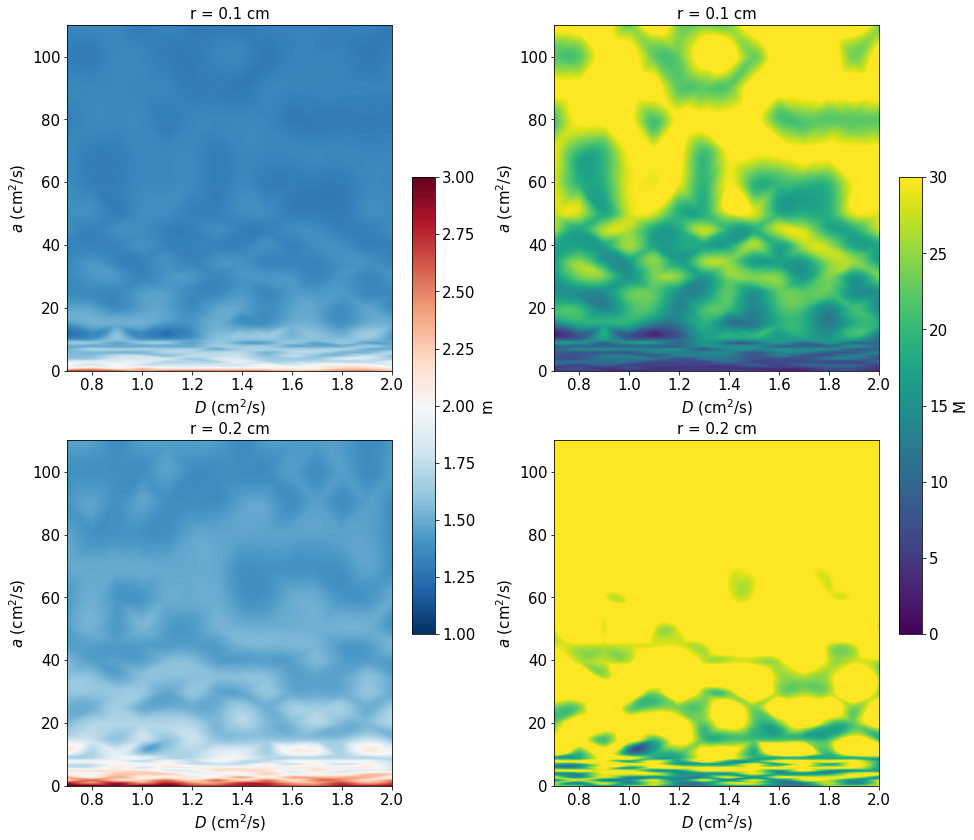

In [836]:
#visualize a versus D
# x2lim=[0,20]
x2lim=[0,110]
x1lim=[0.7,2]#[np.min(x1_values),np.max(x1_values)]
# x1lim=[np.min(x1_values),np.max(x1_values)]
fontsize=15
xlabel=r'$D$ (cm$^2$/s)'
ylabel=r'$a$ (cm$^2$/s)'
cmap = mpl.cm.cool

#TODO: compute the interpolated m (left) and the interpolated M (right) for each pixel.
#HINT: if col==0: # then, get fitted m values
#HINT: if col==1: # then, get fitted M values


#define parameters to be varied
input_cols=['r','D','varkappa']#,x0
# input_cols=['r','kappa','D','varkappa']#,x0
# output_col='m'
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 

#columnal kwargs
vmin_lst=[1,0]
vmax_lst=[3,30]
output_col_lst=['m','M']
#kwargs by row
r_lst=[0.1,0.2]
fig, axs = plt.subplots(2, len(r_lst), figsize=(16,14))
cmaps = ['RdBu_r', 'viridis']
title_foo=lambda r:f'r = {r:.1f} cm'
nsamples=1000
for col in range(2):
    #extract target output value to fit to
    output_col=output_col_lst[col]
    yall=dg[output_col].values
    for row in range(2):
        #restrict to fixed reaction range
        r=r_lst[row]
        title=title_foo(r)#f'r = {r:.1f} cm'
        boo=Xall[:,0]==r
        X=Xall[boo,1:3].copy()  #make the x,y axis the 2nd and 3rd columns of X
        y=yall[boo].copy()
        #TODO: compute the m,M fits
        #TODO: compute the interpolated values of y on this 2D grid
        # interp = LinearNDInterpolator(X, y)
        interp = CloughTocher2DInterpolator(X, y)

        #define the local grid for visualization of N-dim interpolation
        num_cols=X.shape[1]
        xi=[]
        for i in range(num_cols):
            x=X[:,i]
            xi.append( np.linspace(np.min(x), np.max(x),nsamples) )

        XI=np.meshgrid(*xi)
        x1_values=XI[0]
        x2_values=XI[1]

        # np.array(list(zip(XI))).shape
        gridshape=x1_values.shape
        X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
        y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
        
        ax = axs[row, col]
        vmin=vmin_lst[col]
        vmax=vmax_lst[col]
        pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
        
        
        ax.set_xlim(x1lim)
        ax.set_ylim(x2lim)
        ax.set_title(title,fontsize=fontsize)
        format_plot(ax, xlabel, ylabel, fontsize)#, use_loglog=False
        
#     fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(output_col, fontsize=fontsize)    
# plt.tight_layout()
plt.show()

In [834]:
nsamples

1000

In [688]:
# x2lim=[0,20]
# x1lim=[np.min(x1_values),np.max(x1_values)]
# fontsize=20
# # xlabel=r'$r$ (cm)'
# xlabel=r'$D$ (cm$^2$/s)'
# ylabel=r'$a$ (cm$^2$/s)'
# vmin=1
# vmax=3
# cmap = mpl.cm.cool

# #TODO:visualize this slice
# fig, ax = plt.subplots(figsize=(6, 4))
# # ax.pcolormesh(x1_values, x2_values, y_values, shading='auto')
# ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmap)


# # # #format for colorbar
# # # # fig.subplots_adjust(bottom=0.5)
# # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# # fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
# #              cax=ax, orientation='vertical', label='exponent value')


# ax.set_xlim(x1lim)
# ax.set_ylim(x2lim)
# format_plot(ax, xlabel, ylabel, fontsize)#, use_loglog=False
# plt.show()

In [ ]:
# x1lim=[0.05,0.5]#r
# x2lim=[0,20]#a
# # x1lim=[0.7,2]#D [np.min(x1_values),np.max(x1_values)]
# # x1lim=[np.min(x1_values),np.max(x1_values)]
# fontsize=15
# xlabel=r'$r$ (cm)'
# xlabel=r'$D$ (cm$^2$/s)'
# # ylabel=r'$a$ (cm$^2$/s)'
# cmap = mpl.cm.cool

# #TODO: compute the interpolated m (left) and the interpolated M (right) for each pixel.
# #HINT: if col==0: # then, get fitted m values
# #HINT: if col==1: # then, get fitted M values


# #define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
# # input_cols=['r','kappa','D','varkappa']#,x0
# # output_col='m'
# #inputs:dg,input_cols,output_col
# #output: fitted model

# Xall=dg[input_cols].values 
# #D=2
# #columnal kwargs
# vmin_lst=[1,0]
# vmax_lst=[3,30]
# output_col_lst=['m','M']
# #kwargs by row
# r_lst=[0.1,0.2]
# colvar_lst=r_lst
# title_foo=lambda r:f'r = {r:.1f} cm'
# # kappa_lst=[250,500]
# # colvar_lst=kappa_lst
# # title_foo=lambda kappa:f'kappa = {kappa:.1f} cm'


In [306]:
#TODO(for visualization): make a nice visualization using the previous method (just put a line plot of m,M versus a for several r values fixed, and an overall D value, also fixed)
#TODO(later? for visualization): make a nice visualization using the new method 


# TODO(heretim): fix D. fix kappa. Plot the heatmap of m value over a versus r

In [763]:
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
kappa=500
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
query_template=query.copy()
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
input_cols=['r','kappa','D','varkappa']#,x0
output_col='m'
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_col].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
yhat = interp(X)
rmse=np.sqrt(np.mean((yhat-y)**2))
print(f"the rmse of linear interpolation is {rmse:.4f}")

# yhat = interp(X)
print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

number of training examples is 4890.
the rmse of linear interpolation is 0.0000
shape of X (4890, 4) --> shape of y=yhat (4890,)


In [764]:
# TODO: define the query template
query_template=query.copy()

2
(1000000, 2)
((1000, 1000), (1000, 1000), (1000, 1000))
2
(1000000, 2)
((1000, 1000), (1000, 1000), (1000, 1000))


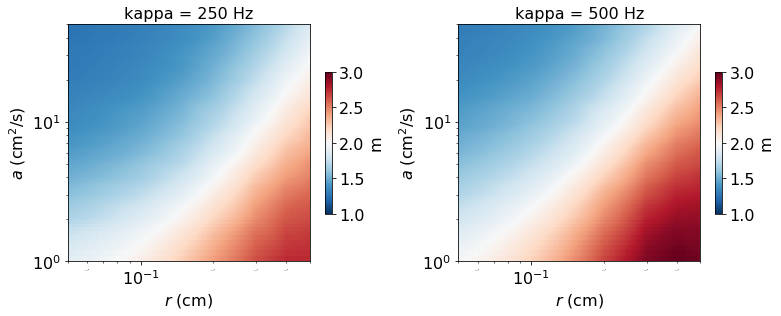

In [858]:
#visualize a versus r
x1lim=[0.05,0.5]
x2lim=[1,50]
# x2lim=[0,50]
fontsize=16
figsize=(11,4.5)#(16,6)#(16,14)
xlabel=r'$r$ (cm)'
ylabel=r'$a$ (cm$^2$/s)'
cmap = mpl.cm.cool
#columnal kwargs
vmin_lst=[1,1]
vmax_lst=[3,3]
# vmin_lst=[1,0]
# vmax_lst=[3,20]
output_col_lst=['m','m']
# output_col_lst=['m','M']
#kwargs by row
# r_lst=[0.1,0.2]
kappa_lst=[250,500]
kappa_col=2
cmaps = ['RdBu_r', 'RdBu_r']
# cmaps = ['RdBu_r', 'viridis']
title_foo=lambda kappa:f'kappa = {kappa:.0f} Hz'
# fig,ax=plt.subplots()
fig,axs=plt.subplots(ncols=2, figsize=figsize)
# fig, axs = plt.subplots(2, len(kappa_lst), figsize=(16,14))
D=2
# kappa=500
nsamples=1000
col=0
kappa_lst=[250,500]
for col,kappa in enumerate(kappa_lst):
    output_col=output_col_lst[col]
    query = (df['D']==D)
    query&= (df['kappa']==kappa)
    query&= query_template
    X=df.loc[query,['r','varkappa']].values
    y_values=df.loc[query,output_col].values
    interp = LinearNDInterpolator(X, y_values)
    # interp = CloughTocher2DInterpolator(X, y_values)

    #TODO: make interpolator that maps X to y values everywhere
    #TODO: make a grid realization of y_values
    #TODO: how do I compute y_values previously?
    #TODO: could this be as easy as a nested for-loop about each pixel value, running y_values=interp(X[j,:])

    #define the local grid for visualization of N-dim interpolation
    num_cols=X.shape[1]
    xi=[]
    for i in range(num_cols):
        x=X[:,i]
        xi.append( np.linspace(np.min(x), np.max(x),nsamples) )
    XI=np.meshgrid(*xi)
    print(len(XI))
    x1_values=XI[0]
    x2_values=XI[1]

    # np.array(list(zip(XI))).shape
    gridshape=x1_values.shape
    X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
    print(X_values.shape)
    y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    # y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    print((x1_values.shape,x2_values.shape,y_values.shape))
    ax=axs[col]
    #ax = axs[row, col]
    #     #plot heatmap in the next axis
    #     #ax = axs[row, col]
    vmin=vmin_lst[col]
    vmax=vmax_lst[col]
    pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
#     pcm=ax.pcolormesh(np.log(x1_values+1), np.log(x2_values+1), y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
    ax.set_xlim(x1lim)
    ax.set_ylim(x2lim)
    title=title_foo(kappa)
    ax.set_title(title,fontsize=fontsize)
    format_plot(ax, xlabel, ylabel, fontsize, use_loglog=False)
    ax.set_xscale('log')
    ax.set_yscale('log')
    cbar=fig.colorbar(pcm, ax=ax, shrink=0.6,label=output_col)#, location='top'
    # fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    #     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(output_col, fontsize=fontsize)    
plt.tight_layout()
plt.show()


2
(1000000, 2)
((1000, 1000), (1000, 1000), (1000, 1000))
2
(1000000, 2)
((1000, 1000), (1000, 1000), (1000, 1000))


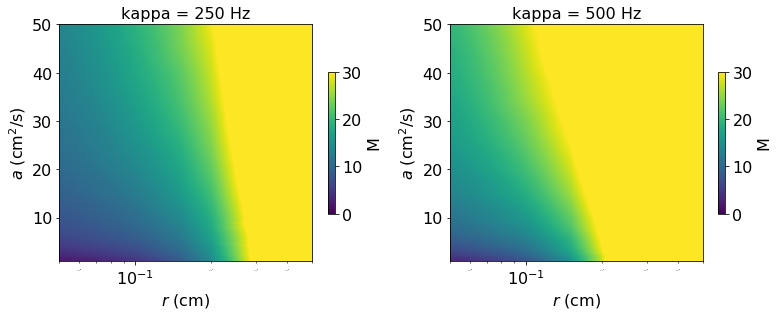

In [867]:
#visualize a versus r
x1lim=[0.05,0.5]
x2lim=[1,50]
# x2lim=[0,50]
fontsize=16
figsize=(11,4.5)#(16,6)#(16,14)
xlabel=r'$r$ (cm)'
ylabel=r'$a$ (cm$^2$/s)'
cmap = mpl.cm.cool
#columnal kwargs
# vmin_lst=[1,1]
# vmax_lst=[3,3]
vmin_lst=[0,0]
vmax_lst=[30,30]
output_col_lst=['M','M']
# output_col_lst=['m','M']
#kwargs by row
# r_lst=[0.1,0.2]
kappa_lst=[250,500]
kappa_col=2
# cmaps = ['RdBu_r', 'RdBu_r']
cmaps = ['viridis', 'viridis']
title_foo=lambda kappa:f'kappa = {kappa:.0f} Hz'
# fig,ax=plt.subplots()
fig,axs=plt.subplots(ncols=2, figsize=figsize)
# fig, axs = plt.subplots(2, len(kappa_lst), figsize=(16,14))
D=2.0
# kappa=500
nsamples=1000
col=0
kappa_lst=[250,500]
for col,kappa in enumerate(kappa_lst):
    output_col=output_col_lst[col]
    query = (df['D']==D)
    query&= (df['kappa']==kappa)
    query&= query_template
    X=df.loc[query,['r','varkappa']].values
    y_values=df.loc[query,output_col].values
    interp = LinearNDInterpolator(X, y_values)
    # interp = CloughTocher2DInterpolator(X, y_values)

    #TODO: make interpolator that maps X to y values everywhere
    #TODO: make a grid realization of y_values
    #TODO: how do I compute y_values previously?
    #TODO: could this be as easy as a nested for-loop about each pixel value, running y_values=interp(X[j,:])

    #define the local grid for visualization of N-dim interpolation
    num_cols=X.shape[1]
    xi=[]
    for i in range(num_cols):
        x=X[:,i]
        xi.append( np.linspace(np.min(x), np.max(x),nsamples) )
    XI=np.meshgrid(*xi)
    print(len(XI))
    x1_values=XI[0]
    x2_values=XI[1]

    # np.array(list(zip(XI))).shape
    gridshape=x1_values.shape
    X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
    print(X_values.shape)
    y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    # y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    print((x1_values.shape,x2_values.shape,y_values.shape))
    ax=axs[col]
    #ax = axs[row, col]
    #     #plot heatmap in the next axis
    #     #ax = axs[row, col]
    vmin=vmin_lst[col]
    vmax=vmax_lst[col]
    pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
#     pcm=ax.pcolormesh(np.log(x1_values+1), np.log(x2_values+1), y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
    ax.set_xlim(x1lim)
    ax.set_ylim(x2lim)
    title=title_foo(kappa)
    ax.set_title(title,fontsize=fontsize)
    format_plot(ax, xlabel, ylabel, fontsize, use_loglog=False)
    ax.set_xscale('log')
#     ax.set_yscale('log')
    cbar=fig.colorbar(pcm, ax=ax, shrink=0.6,label=output_col)#, location='top'
    # fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    #     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(output_col, fontsize=fontsize)    
plt.tight_layout()
plt.show()


In [ ]:
#visualize a versus r
x1lim=[0.05,0.5]
x2lim=[1,50]
# x2lim=[0,50]
fontsize=16
figsize=(11,4.5)#(16,6)#(16,14)
xlabel=r'$r$ (cm)'
ylabel=r'$a$ (cm$^2$/s)'
cmap = mpl.cm.cool
#columnal kwargs
# vmin_lst=[1,1]
# vmax_lst=[3,3]
vmin_lst=[0,0]
vmax_lst=[30,30]
output_col_lst=['M','M']
# output_col_lst=['m','M']
#kwargs by row
# r_lst=[0.1,0.2]
kappa_lst=[250,500]
kappa_col=2
# cmaps = ['RdBu_r', 'RdBu_r']
cmaps = ['viridis', 'viridis']
title_foo=lambda kappa:f'kappa = {kappa:.0f} Hz'
# fig,ax=plt.subplots()
fig,axs=plt.subplots(ncols=2, figsize=figsize)
# fig, axs = plt.subplots(2, len(kappa_lst), figsize=(16,14))
D=2.0
# kappa=500
nsamples=1000
col=0
kappa_lst=[250,500]
for col,kappa in enumerate(kappa_lst):
    output_col=output_col_lst[col]
    query = (df['D']==D)
    query&= (df['kappa']==kappa)
    query&= query_template
    X=df.loc[query,['r','varkappa']].values
    y_values=df.loc[query,output_col].values
    interp = LinearNDInterpolator(X, y_values)
    # interp = CloughTocher2DInterpolator(X, y_values)

    #TODO: make interpolator that maps X to y values everywhere
    #TODO: make a grid realization of y_values
    #TODO: how do I compute y_values previously?
    #TODO: could this be as easy as a nested for-loop about each pixel value, running y_values=interp(X[j,:])

    #define the local grid for visualization of N-dim interpolation
    num_cols=X.shape[1]
    xi=[]
    for i in range(num_cols):
        x=X[:,i]
        xi.append( np.linspace(np.min(x), np.max(x),nsamples) )
    XI=np.meshgrid(*xi)
    print(len(XI))
    x1_values=XI[0]
    x2_values=XI[1]

    # np.array(list(zip(XI))).shape
    gridshape=x1_values.shape
    X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
    print(X_values.shape)
    y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    # y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    print((x1_values.shape,x2_values.shape,y_values.shape))
    ax=axs[col]
    #ax = axs[row, col]
    #     #plot heatmap in the next axis
    #     #ax = axs[row, col]
    vmin=vmin_lst[col]
    vmax=vmax_lst[col]
    pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
#     pcm=ax.pcolormesh(np.log(x1_values+1), np.log(x2_values+1), y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
    ax.set_xlim(x1lim)
    ax.set_ylim(x2lim)
    title=title_foo(kappa)
    ax.set_title(title,fontsize=fontsize)
    format_plot(ax, xlabel, ylabel, fontsize, use_loglog=False)
    ax.set_xscale('log')
#     ax.set_yscale('log')
    cbar=fig.colorbar(pcm, ax=ax, shrink=0.6,label=output_col)#, location='top'
    # fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    #     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(output_col, fontsize=fontsize)    
plt.tight_layout()
plt.show()

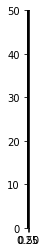

In [872]:
contours = plt.contour(x1_values, x2_values, y_values, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(y_values, extent=[0.05, 0.5, 0, 50], origin='lower',
           cmap='RdGy', alpha=0.5)
# plt.colorbar();

In [873]:
1

[autoreload of lib.measure failed: Traceback (most recent call last):
  File "/home/timothytyree/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/timothytyree/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/timothytyree/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/timothytyree/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/timothytyree/Documents/GitHub/bgmc/python/lib/measure/__init__.py", line 5, in <module>
    from .measure_care import *
  File "/home/timothy

1

## der scratchwerk%

In [826]:
#TODO: for a given local m measure in the r,a plane, compute the lewiner level set for a square lattice via the lookup-table implementation.

In [ ]:
#GOAL: level sets
#TODO: copy existing method of level sets here!!!
#heretim

In [759]:
X.shape,y_values.shape

((175, 2), (175,))

In [757]:
#  plot heatmap in the next axis
#ax = axs[row, col]
#     vmin=vmin_lst[col]
#     vmax=vmax_lst[col]
pcm=ax.pcolormesh(x1_values, x2_values, y_values)#, vmin=vmin, vmax=vmax, cmap=cmaps[col])


ValueError: not enough values to unpack (expected 2, got 1)

In [758]:
X.shape,x1_values.shape,x2_values.shape,y_values.shape

((175, 2), (50, 50), (50, 50), (175,))

In [760]:
#define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
input_cols=['r','kappa','D','varkappa']#,x0
output_col='m'
#inputs:dg,input_cols,output_col
#output: fitted model

#solution for the r,D,a basis
#restrict to fixed reaction range
# r=0.1 #cm
D=2
fixed_value=D#r
fixed_row=1

unfixed_rows=[0,2]
boo=Xall[:,fixed_row]==fixed_value
X=Xall[boo,1:3].copy()
X[:,0]=Xall[boo,unfixed_rows[0]].copy()
X[:,1]=Xall[boo,unfixed_rows[1]].copy()
X[:,1]=Xall[boo,unfixed_rows[1]].copy()
y=yall[boo].copy()

#define the local grid for visualization of N-dim interpolation
num_cols=X.shape[1]
xi=[]
for i in range(num_cols):
    x=X[:,i]
    xi.append( np.linspace(np.min(x), np.max(x)) )

XI=np.meshgrid(*xi)
print(len(XI))

x1_values=XI[0]
x2_values=XI[1]



ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
        #heretim
        X=Xall[boo,1:3].copy()  #make the x,y axis the 2nd and 3rd columns of X
        y=yall[boo].copy()
        #TODO: compute the m,M fits
        #TODO: compute the interpolated values of y on this 2D grid
        # interp = LinearNDInterpolator(X, y)
        interp = CloughTocher2DInterpolator(X, y)

        #define the local grid for visualization of N-dim interpolation
        num_cols=X.shape[1]
        xi=[]
        for i in range(num_cols):
            x=X[:,i]
            xi.append( np.linspace(np.min(x), np.max(x)) )
        XI=np.meshgrid(*xi)
        x1_values=XI[0]
        x2_values=XI[1]

        # np.array(list(zip(XI))).shape
        gridshape=x1_values.shape
        X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
        y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
        
        ax = axs[row, col]
        vmin=vmin_lst[col]
        vmax=vmax_lst[col]
        pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
       
    
    

In [717]:


# np.array(list(zip(XI))).shape
gridshape=x1_values.shape
X_values=np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T


#TODO: compute the interpolated values of y on this 2D grid
# interp = LinearNDInterpolator(X, y)
interp = CloughTocher2DInterpolator(X, y)
y_values = interp(X_values).reshape(gridshape[0],gridshape[1])
y_values.shape
# ,X_values.shape,x1_values.shape
# y_values.reshape?

(50, 50)

ValueError: No points given

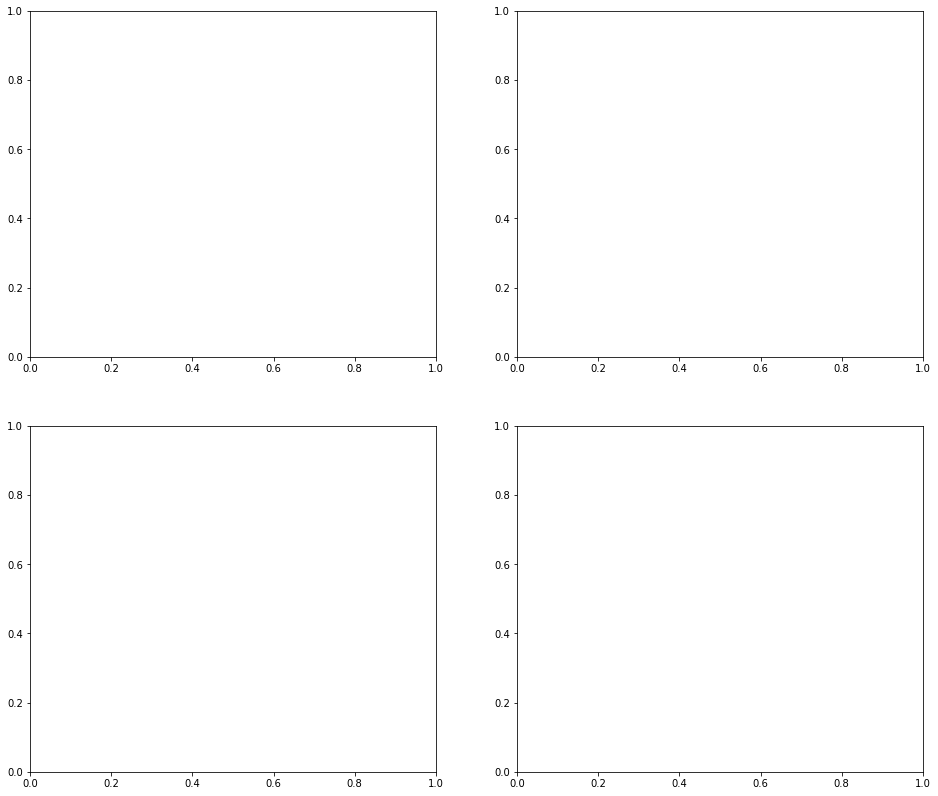

In [718]:
#visualize a versus r
x2lim=[0,20]
x1lim=[0.05,0.5]#[np.min(x1_values),np.max(x1_values)]
# x1lim=[np.min(x1_values),np.max(x1_values)]
fontsize=15
xlabel=r'$r$ (cm)'
ylabel=r'$a$ (cm$^2$/s)'
cmap = mpl.cm.cool

#TODO: compute the interpolated m (left) and the interpolated M (right) for each pixel.
#HINT: if col==0: # then, get fitted m values
#HINT: if col==1: # then, get fitted M values

Xall=dg[input_cols].values 

#columnal kwargs
vmin_lst=[1,0]
vmax_lst=[3,30]
output_col_lst=['m','M']
#kwargs by row
# r_lst=[0.1,0.2]
kappa_lst=[250,500]
kappa_col=2
fig, axs = plt.subplots(2, len(kappa_lst), figsize=(16,14))
cmaps = ['RdBu_r', 'viridis']
title_foo=lambda kappa:f'kappa = {kappa:.1f} Hz'

for col in range(2):
    #extract target output value to fit to
    output_col=output_col_lst[col]
    yall=dg[output_col].values
    for row in range(2):
        #restrict to fixed reaction range
        kappa=kappa_lst[row]
        title=title_foo(kappa)#f'r = {r:.1f} cm'
        boo=Xall[:,kappa_col]==kappa
        
        
        #heretim
        X=Xall[boo,1:3].copy()  #make the x,y axis the 2nd and 3rd columns of X
        y=yall[boo].copy()
        #TODO: compute the m,M fits
        #TODO: compute the interpolated values of y on this 2D grid
        # interp = LinearNDInterpolator(X, y)
        interp = CloughTocher2DInterpolator(X, y)

        #define the local grid for visualization of N-dim interpolation
        num_cols=X.shape[1]
        xi=[]
        for i in range(num_cols):
            x=X[:,i]
            xi.append( np.linspace(np.min(x), np.max(x)) )
        XI=np.meshgrid(*xi)
        x1_values=XI[0]
        x2_values=XI[1]

        # np.array(list(zip(XI))).shape
        gridshape=x1_values.shape
        X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
        y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
        
        ax = axs[row, col]
        vmin=vmin_lst[col]
        vmax=vmax_lst[col]
        pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
        
        
        ax.set_xlim(x1lim)
        ax.set_ylim(x2lim)
        ax.set_title(title,fontsize=fontsize)
        format_plot(ax, xlabel, ylabel, fontsize)#, use_loglog=False
        
#     fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(output_col, fontsize=fontsize)    
# plt.tight_layout()
plt.show()

# TODO(for concrete results): compute a reasonable set of r,D,a values for the m,M corresponding to the full models

In [326]:
# # interp.tri?
# # Examples
# # --------
# # Triangulation of a set of points:

# points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
# from scipy.spatial import Delaunay
# tri = Delaunay(points)

# # We can plot it:

# import matplotlib.pyplot as plt
# plt.triplot(points[:,0], points[:,1], tri.simplices)
# plt.plot(points[:,0], points[:,1], 'o')
# plt.show()

In [328]:
# # Point indices and coordinates for the two triangles forming the triangulation:
# print(tri.simplices)

# # Note that depending on how rounding errors go, the simplices may
# # be in a different order than above.
# print(points[tri.simplices])
# # Triangle 0 is the only neighbor of triangle 1, and it's opposite to vertex 1 of triangle 1:

# print((tri.neighbors[1],points[tri.simplices[1,1]]))

# # We can find out which triangle points are in:

# p = np.array([(0.1, 0.2), (1.5, 0.5), (0.5, 1.05)])
# print(tri.find_simplex(p))
# # The returned integers in the array are the indices of the simplex the
# # corresponding point is in. If -1 is returned, the point is in no simplex.
# # Be aware that the shortcut in the following example only works corretcly
# # for valid points as invalid points result in -1 which is itself a valid
# # index for the last simplex in the list.

# p_valids = np.array([(0.1, 0.2), (0.5, 1.05)])
# tri.simplices[tri.find_simplex(p_valids)]

# # We can also compute barycentric coordinates in triangle 1 for these points:

# b = tri.transform[1,:2].dot(np.transpose(p - tri.transform[1,2]))
# np.c_[np.transpose(b), 1 - b.sum(axis=0)]

# # The coordinates for the first point are all positive, meaning it
# # is indeed inside the triangle. The third point is on a vertex,
# # hence its null third coordinate.

In [437]:
# Recall powerlaw fits to full models
# Fenton-Karma(PBC) 
m, Delta_m, M, Delta_M = 1.8772341309722325, 0.02498750277237229, 5.572315674840435, 0.3053120355191732
# Luo-Rudy(PBC) 
m, Delta_m, M, Delta_M = 1.6375562704001745, 0.017190912126700632, 16.73559858353835, 0.8465090320196467

# # Fenton-Karma(NCBC) 
# m, Delta_m, M, Delta_M = 1.854156794480594, 0.02503190538288011, 7.135532649256895, 0.4548432215549294
# # Luo-Rudy(NCBC) 
# m, Delta_m, M, Delta_M = 1.6611400039209043, 0.02740424198712116, 16.75061667963681, 1.3110747548319708

#TODO: find the values closest to m
ytrgt=M
k=20
input_cols=['r','kappa', 'D', 'varkappa']
output_col='m'

In [436]:
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
kappa=500
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
# input_cols=['r','kappa','D','varkappa']#,x0

#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_col].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'the number of training examples is {m:d}')
try:
    interp = LinearNDInterpolator(X, y)
    yhat = interp(X)
    rmse=np.sqrt(np.mean((yhat-y)**2))
except Exception as e:
    #print('Warning: '+e) #QhullError...
    interp = LinearNDInterpolator(X, y)
    yhat = interp(X)
    rmse=np.sqrt(np.mean((yhat-y)**2))
# # interp = CloughTocher2DInterpolator(X, y)
# yhat = interp(X)
# rmse=np.sqrt(np.mean((yhat-y)**2))
print(f"the rmse of ordinairy interpolation is {rmse:.4f}")

# #forked from:
# interp = LinearNDInterpolator(X, y)
# # interp = CloughTocher2DInterpolator(X, y)
# yhat = interp(X)
# rmse=np.sqrt(np.mean((yhat-y)**2))
# print(f"the rmse of simple interpolation is {rmse:.4f}")

the number of training examples is 2450


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qc Qt Q12 Qbb Qz
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1424710694  delaunay  Qcoplanar-keep  Qtriangulate  Q12-allow-wide
  Qbbound-last  Qz-infinity-point  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 1.1e+02  Error-roundoff 1.4e-12  _one-merge 1.5e-11
  Visible-distance 8.2e-12  U-max-coplanar 8.2e-12  Width-outside 1.6e-11
  _wide-facet 4.9e-11  _maxoutside 1.6e-11

precision problems (corrected unless 'Q0' or an error)
      6 nearly singular or axis-parallel hyperplanes
      6 zero divisors during back substitute
   4899 zero divisors during gaussian elimination

The input to qhull appears to be less than 5 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p4(v6):  0.05 5e+02   1.4     0 0.019
- p12(v5):   0.4 5e+02     2     6  0.52
- p22(v4):   0.1 5e+02   0.7     2 0.052
- p0(v3):   0.4 5e+02   1.6     1 0.042
- p26(v2):   0.5 5e+02   0.9    50    33
- p1(v1):  0.05 5e+02   1.9     1 0.054

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.4e-12.  The center point, facets and distances
to the center point are as follows:

center point     0.25      500    1.417       10    5.553

facet p12 p22 p0 p26 p1 distance=    0
facet p4 p22 p0 p26 p1 distance=    0
facet p4 p12 p0 p26 p1 distance=    0
facet p4 p12 p22 p26 p1 distance=    0
facet p4 p12 p22 p0 p1 distance=    0
facet p4 p12 p22 p0 p26 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:      0.05       0.5  difference= 0.45
  1:       500       500  difference=    0
  2:       0.7         2  difference=  1.3
  3:         0       110  difference=  110
  4:         0       500  difference=  500

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.4e-12.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


In [397]:
df[output_col]

0       1.477497
1       1.726534
2       1.361442
3       3.050656
4       1.961670
          ...   
9785    1.367459
9786    1.394982
9787    1.423513
9788    2.017669
9789    1.273696
Name: m, Length: 9790, dtype: float64

In [398]:
print(f"printing the {k} indices closest to {ytrgt}")
unsorted_series=np.abs(df[output_col]-m)
indices_of_sorted=unsorted_series.argsort()
smallest_deviations=indices_of_sorted.loc[:k].values
df.loc[smallest_deviations]

printing the 5 indices closest to 16.73559858353835


,m,Delta_m,M,Delta_M,Rsq,rmse,q_min,q_max,r,kappa,D,varkappa,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction
7876,3.704631,0.129738,113.284370,42.670525,0.972976,11.654004,0.1,1.0,0.4,500,0.7,0,0,10,2,0,1,0,0,0
9716,3.687513,0.077974,66.923404,14.514080,0.989975,4.409222,0.1,1.0,0.3,500,0.7,0,0,10,2,0,1,0,0,0
6976,3.643788,0.078303,68.932836,15.323308,0.989650,4.748950,0.1,1.0,0.3,500,0.7,0,0,10,2,0,0,0,0,0
3507,3.629814,0.074804,67.008355,13.880472,0.990474,4.265267,0.1,1.0,0.3,500,0.8,0,0,10,2,0,1,0,0,0
6712,3.621501,0.123402,116.287049,42.143416,0.974379,11.760432,0.1,1.0,0.4,500,0.7,0,0,10,2,0,0,0,0,0
3561,3.612594,0.124107,110.794638,39.655037,0.973968,11.233757,0.1,1.0,0.4,500,0.8,0,0,10,2,0,1,0,0,0


## TODO: implement genetic algorithm to find the best fit combination of r,D,a:=varkappa for a given kappa
- Hint: copy the src/gener_run_X.py implementation of the genetic algorithm here. OR 

 __Methods__ Method for genetically optimizated fit of the apparent powerlaw. 
 - Step 1: choose best k=2 or 3 for a given set of sample r,D,varkappa,kappa pairs
 - Step 2: generate N=1000 random sample targets centered about the mean of ^these reproducing elite sample values.  Compute predicted output values.
   - Hint: Results may be generated using piecewise linear interpolation for these sammples to save an exceptional amount of computational time.
 - repeat ^these last couple steps some number of times, K.
 - Perform a principle component analysis on the final iterate of ^that sample generation process.
 - select the output vector closest to the desired output value, here (m,M)
 - perform ./return_CollTimes.sh on this parameter value.  Conside improving performance with more iterates of steps 1 and 2.

In [400]:
# TODO: copy the cells from the dev_run.ipynb 

In [401]:
#TODO: recall from up ^there that I have X,y to fit, for X.shape=(n_samples,n_dimensions:=3)
#TODO: modify ^this to dev a genetic optimization problem 

# __Methods__
# - Step 1: choose best k=2 or 3 for a given set of sample r,D,varkappa,kappa pairs
# - Step 2: generate N=1000 random sample targets centered about the mean of ^these reproducing elite sample values.  Compute predicted output values.
#   - Hint: Results may be generated using piecewise linear interpolation for these sammples to save an exceptional amount of computational time.
# - repeat ^these last couple steps some number of times, K.
# - Perform a principle component analysis on the final iterate of ^that sample generation process.
# - select the output vector closest to the desired output value, here (m,M)
# - perform ./return_CollTimes.sh on this parameter value.  Conside improving performance with more iterates of steps 1 and 2.

In [402]:
#TODO: determine the elite superior
#TODO: make a map from a number of points (K nearest neighbors, wrt m or separately M) to a correlation matrix
#TODO: generate points about the mean randomly using ^that correlation matrix
#TODO: test those points

# boltzmann defect weighting of the K nearest neighbors

- DONE: do ^this with the inverse powerlaw data (force_code==2)
- TODO(later): do ^this with the anti-hookean data (force_code==1)

In [403]:
K=5

In [404]:
df.mean()

m                  1.842765
Delta_m            0.019784
M                 51.154500
Delta_M            4.119574
Rsq                0.997069
rmse               1.378296
q_min              0.100000
q_max              1.000000
r                  0.243054
kappa            375.127681
D                  1.350133
varkappa          33.033708
x0                 0.000000
L                 10.000000
force_code         2.000000
neighbor           0.000000
reflect            0.500511
set_second         0.000000
no_repulsion       0.000000
no_attraction      0.000000
dtype: float64

In [405]:
df.loc[smallest_deviations, input_cols]

,r,kappa,D,varkappa
7876,0.4,500,0.7,0
9716,0.3,500,0.7,0
6976,0.3,500,0.7,0
3507,0.3,500,0.8,0
6712,0.4,500,0.7,0
3561,0.4,500,0.8,0


In [406]:
df.loc[smallest_deviations, output_col]

7876    3.704631
9716    3.687513
6976    3.643788
3507    3.629814
6712    3.621501
3561    3.612594
Name: m, dtype: float64

In [468]:
# #TODO: wrap this 
# def comp_boltzman_weighted_weights(output_disagreement_values,**kwargs):
#     mean_free_energy=np.mean(0.5*output_disagreement_values**2)
#     weight_values=np.exp(-output_disagreement_values/mean_free_energy)
#     the_partition_function=np.sum(weight_values)
#     weight_values/=the_partition_function
#     return weight_values
    
# def comp_boltzman_weighted_mean(output_disagreement_values,**kwargs):
#     '''compute the boltzman weighted average of these K elite members'''
#     weight_values=comp_boltzman_weighted_weights(output_disagreement_values,**kwargs)
#     result_values=output_disagreement_values*weight_values
#     mean_value=np.mean(result_values)
#     return mean_value
# #     print(f"the sum of the weights is {sum(weight_values)}") # one

In [380]:
#TODO: wrap ^this into a function
#TODO: repeat ^this with M
#TODO: put ^that into an output_vector, (m1,M(m1)) and for the M optimized K=5 elite members, (m(M2),M2).  Then, consider seeding the next generation with a correlation matrix times a normally distributed random variable, plus a  random linear interpolant of the fitting points for the K=5 elite of m1_values and M2_values

In [475]:
cols

['r', 'kappa', 'D', 'varkappa', 'm', 'M']

In [476]:
#TODO: Boltzman Defect Weighting
m1_values=df.loc[smallest_deviations, cols].values
# TODO: and M2_values

output_values=m1_values

In [477]:
# Recall powerlaw fits to full models

#TODO: find the values closest to m
ytrgt=M
k=20
input_cols=['r','kappa', 'D', 'varkappa']
output_col='m'

# Fenton-Karma(PBC) 
m, Delta_m, M, Delta_M = 1.8772341309722325, 0.02498750277237229, 5.572315674840435, 0.3053120355191732
wjr={
    'fk_pbc':{'m':m, 'Delta_m':Delta_m, 'M':M, 'Delta_M':Delta_M}
}

#TODO: insert compute of LR 
# Luo-Rudy(PBC) 
m, Delta_m, M, Delta_M = 1.6375562704001745, 0.017190912126700632, 16.73559858353835, 0.8465090320196467
wjr['lr_pbc']={'m':m, 'Delta_m':Delta_m, 'M':M, 'Delta_M':Delta_M}
print(wjr)

{'fk_pbc': {'m': 1.8772341309722325, 'Delta_m': 0.02498750277237229, 'M': 5.572315674840435, 'Delta_M': 0.3053120355191732}, 'lr_pbc': {'m': 1.6375562704001745, 'Delta_m': 0.017190912126700632, 'M': 16.73559858353835, 'Delta_M': 0.8465090320196467}}


In [533]:
# # result_values
# list(df.columns)
(weight_values*elite_parameter_values[:,1]**2).shape


(6,)

In [538]:
model_name_lst=['fk_pbc','lr_pbc']
output_col_lst=['m','M']
cols=list(input_cols)
cols.extend(output_col_lst)
k=6
m1avg_lst=[]
M2avg_lst=[]
dict_bwm={} #dictiionary of boltzmann weighted mean values
dict_pca={}
smallest_deviations_lst=[]
#for 2-dimensional target space, such as m,M
for model_name in model_name_lst:
    #for m
    Ytrgt=(wjr[model_name][output_col_lst[0]],wjr[model_name][output_col_lst[1]])
    ytrgt=Ytrgt[0]
    print(f"\nfor the {model_name} model...")
#     print(f"printing the {k} indices closest to m={ytrgt}")
    unsorted_series=np.abs(df[output_col]-ytrgt)
    indices_of_sorted=unsorted_series.argsort()
    smallest_deviations=indices_of_sorted.loc[:k-1].values
#     print(df.loc[smallest_deviations,cols])
    smallest_deviations_lst.append(smallest_deviations)
    #compute the boltzmann weighted mean m
    output_disagreement_values=df.loc[smallest_deviations,output_col].values
    boltzman_weighted_mean=comp_boltzman_weighted_mean(output_disagreement_values,**kwargs)
#     print(f"the boltzman_weighted_mean for the K={k} elite members was {boltzman_weighted_mean}")
    m1avg_lst.append(boltzman_weighted_mean)
        
    #compute the boltzmann weighted average w.r.t. m
    weight_values=comp_boltzman_weighted_weights(output_disagreement_values,**kwargs)
    elite_parameter_values=df.loc[smallest_deviations].values#,cols]
    
    #correctly combine Delta_m [1] and Delta_M [3] as the sum of squared variances
    elite_parameter_values[:,1]=weight_values*elite_parameter_values[:,1]**2
    elite_parameter_values[:,3]=weight_values*elite_parameter_values[:,3]**2
    average_values=np.sum(weight_values*elite_parameter_values.T,axis=1)
    average_values[1]=np.sqrt(average_values[1])
    average_values[3]=np.sqrt(average_values[3])
    dict_out=dict(zip(list(df.columns),average_values))
    dict_bwm[model_name+'_m']=dict_out
    print(f"the boltzman_weighted mean parameter for the K={k} elite members was {dict_out}")
 
    #TODO: compute the correlation matrix/PCA on the mean squared differences?/just take random linear combinations in the interpolating space and take the max value
    
    #for M
    ytrgt=Ytrgt[1]
#     print(f"\nprinting the {k} indices closest to M={ytrgt}")
    unsorted_series=np.abs(df[output_col]-ytrgt)
    indices_of_sorted=unsorted_series.argsort()
    smallest_deviations=indices_of_sorted.loc[:k-1].values
#     print(df.loc[smallest_deviations,cols])
    
    #compute the boltzmann weighted mean m
    output_disagreement_values=df.loc[smallest_deviations,output_col].values
    boltzman_weighted_mean=comp_boltzman_weighted_mean(output_disagreement_values,**kwargs)
#     print(f"the boltzman_weighted_mean for the K={k} elite members was {boltzman_weighted_mean}")
    M2avg_lst.append(boltzman_weighted_mean)
        
    #compute the boltzmann weighted average w.r.t. m
    weight_values=comp_boltzman_weighted_weights(output_disagreement_values,**kwargs)
    elite_parameter_values=df.loc[smallest_deviations].values#,cols]
    dict_out=dict(zip(list(df.columns),np.sum(weight_values*elite_parameter_values.T,axis=1)))
    dict_bwm[model_name+'_M']=dict_out
#     print(f"the boltzman_weighted mean parameter for the K={k} elite members was {dict_out}")
    
    #TODO: perform PCA on the outputs minus this dict


for the fk_pbc model...
the boltzman_weighted mean parameter for the K=6 elite members was {'m': 1.877495768958186, 'Delta_m': 0.003910137278198711, 'M': 106.54991693946528, 'Delta_M': 1.7678825269489105, 'Rsq': 0.9994109955723661, 'rmse': 1.2860529670389256, 'q_min': 0.09999999999999998, 'q_max': 0.9999999999999999, 'r': 0.4166610342552804, 'kappa': 416.6750906107605, 'D': 1.366664677709941, 'varkappa': 46.6662885441238, 'x0': 0.0, 'L': 9.999999999999998, 'force_code': 1.9999999999999998, 'neighbor': 0.0, 'reflect': 0.4999540576848303, 'set_second': 0.0, 'no_repulsion': 0.0, 'no_attraction': 0.0}

for the lr_pbc model...
the boltzman_weighted mean parameter for the K=6 elite members was {'m': 1.637570612053691, 'Delta_m': 0.009006439598070631, 'M': 14.17553046748441, 'Delta_M': 0.32446421675181075, 'Rsq': 0.9959075092522057, 'rmse': 0.35893648465400807, 'q_min': 0.09999999999999998, 'q_max': 0.9999999999999998, 'r': 0.10833280016164487, 'kappa': 416.66862814504043, 'D': 1.28332179622

In [520]:
print(dict_bwm['fk_pbc_m'])


{'m': 1.877495768958186, 'Delta_m': 0.009530726455452318, 'M': 106.54991693946528, 'Delta_M': 3.856707202089051, 'Rsq': 0.9994109955723661, 'rmse': 1.2860529670389256, 'q_min': 0.09999999999999998, 'q_max': 0.9999999999999999, 'r': 0.4166610342552804, 'kappa': 416.6750906107605, 'D': 1.366664677709941, 'varkappa': 46.6662885441238, 'x0': 0.0, 'L': 9.999999999999998, 'force_code': 1.9999999999999998, 'neighbor': 0.0, 'reflect': 0.4999540576848303, 'set_second': 0.0, 'no_repulsion': 0.0, 'no_attraction': 0.0}


__observations__
- the mean of the boltzman weights is approximately zero to roughly at least three significant figures here...

In [521]:
#TODO: compute m boltzman weighted average as m1
#TODO: compute M boltzman weighted average as M2

#TODO: dev compute_M(m1) via interpolation near output_cols=(r,kappa,D,varkappa)
#TODO: dev compute_m(M2)

#TODO: plot the linear interpolation of m,M using plt.plot()
# print(list(zip((model_name_lst,output_col_lst,m1avg_lst,M2avg_lst))))

print(dict_bwm['fk_pbc_m'])
print(f"""the boltzman weighted mean exponent fitted to the Luo-Rudy model was
m_lr_observed_bwm :{dict_bwm['fk_pbc_m']['m']:.5f} +- {dict_bwm['fk_pbc_m']['Delta_m']:.5f}
m_lr_expected_wjr : {wjr['fk_pbc']['m']:.5f} +- {wjr['fk_pbc']['Delta_m']:.5f}

With mean parameters

""")

#TODO: compute the two points
#TODO: interpolate as boltzman_weighted_mean
#TODO: dev compute_boltzman_weighted_cov... Hint: check numpy.linalg.
#TODO: using interp, generate 1000 novel offspring... and also include the original line in the coming progeny...

{'m': 1.877495768958186, 'Delta_m': 0.009530726455452318, 'M': 106.54991693946528, 'Delta_M': 3.856707202089051, 'Rsq': 0.9994109955723661, 'rmse': 1.2860529670389256, 'q_min': 0.09999999999999998, 'q_max': 0.9999999999999999, 'r': 0.4166610342552804, 'kappa': 416.6750906107605, 'D': 1.366664677709941, 'varkappa': 46.6662885441238, 'x0': 0.0, 'L': 9.999999999999998, 'force_code': 1.9999999999999998, 'neighbor': 0.0, 'reflect': 0.4999540576848303, 'set_second': 0.0, 'no_repulsion': 0.0, 'no_attraction': 0.0}


In [ ]:
r=dict_bwm['fk_pbc_m']['r']


In [496]:
#compute the linear ND interpolating function mapping the parameter space to the output m space, restricting to 4 variables

#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
# kappa=500
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
input_cols=['r','kappa','D','varkappa']#,x0
output_col='m'
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_col].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
yhat = interp(X)
rmse=np.sqrt(np.mean((yhat-y)**2))
print(f"the rmse of simple interpolation is {rmse:.4f}")

# yhat = interp(X)
print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

number of training examples is 4890.
the rmse of simple interpolation is 0.0000
shape of X (4890, 4) --> shape of y=yhat (4890,)


# plot the top 1 trials for either full model
- using a log(w) versus log(q) plot 
- with particle data scatterplotted to overlay the powerlaw fits of the full models
- wrap ^this functionally into a function that takes an input ax,df_particle_drates and plots the scatterplot data and the fit
- generate a run_15_top_6.pdf using bluf.py

In [561]:
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all.csv"
df_raw=pd.read_csv(input_fn)
#derived values
# df_raw['CollRate']=1./df_raw['CollTime']
df_raw['A']=df_raw['L']**2
df_raw['q']=df_raw['N']/df_raw['A'] #number of tips per square centimeter
df_raw['w']=df_raw['CollRate']/df_raw['A'] #[mHz?]/cm^2

In [562]:
k=0#for k in range(len(smallest_deviations_lst[0])):
trial_index_1=smallest_deviations_lst[0][k]
trial_index_2=smallest_deviations_lst[1][k]

In [608]:
#compute the powerlaw fitted values for the k^th best exponent (i) with and (ii) without scaling
# FK model
x_values=np.linspace(0.1,1,91)
d=df.loc[trial_index_1]
yhat1=d['M']*x_values**d['m']
yhat1_scaled=wjr['fk_pbc']['M']*x_values**d['m']
scale_factor1=wjr['fk_pbc']['M']/d['M']

#computation of tscores
t_m_FK=(wjr['fk_pbc']['m']-d['m'])/np.max((wjr['fk_pbc']['Delta_m'],d['Delta_m']))
print(f"t_m_FK={t_m_FK:.5f}")

#query the DataFrame for this d
query =(df_raw.set_second==d['set_second'])&(df_raw.reflect==d['reflect'])
query&=(df_raw.no_repulsion==d['no_repulsion'])&(df_raw.no_attraction==d['no_attraction'])
query&=(df_raw.neighbor==int(d['neighbor']))&(df_raw.force_code==int(d['force_code']))
query&=df_raw.r==d['r']
query&=df_raw.kappa==d['kappa']
query&=df_raw.D==d['D']
query&=df_raw.L==d['L']
query&=df_raw.varkappa==d['varkappa']
query&=df_raw.x0==d['x0']
dg=df_raw[query]
#and extract the xy values
x1_values=dg.q.values
y1_values=dg.w.values
y1_scaled_values=y1_values*scale_factor1

#LR model
d=df.loc[trial_index_2]
yhat2=d['M']*x_values**d['m']
yhat2_scaled=wjr['lr_pbc']['M']*x_values**d['m']
scale_factor2=wjr['lr_pbc']['M']/d['M']

#computation of tscores
t_m_LR=(wjr['lr_pbc']['m']-d['m'])/np.max((wjr['lr_pbc']['Delta_m'],d['Delta_m']))
print(f"t_m_LR={t_m_LR:.5f}")

#query the DataFrame for this d
query =(df_raw.set_second==d['set_second'])&(df_raw.reflect==d['reflect'])
query&=(df_raw.no_repulsion==d['no_repulsion'])&(df_raw.no_attraction==d['no_attraction'])
query&=(df_raw.neighbor==int(d['neighbor']))&(df_raw.force_code==int(d['force_code']))
query&=df_raw.r==d['r']
query&=df_raw.kappa==d['kappa']
query&=df_raw.D==d['D']
query&=df_raw.L==d['L']
query&=df_raw.varkappa==d['varkappa']
query&=df_raw.x0==d['x0']
dg=df_raw[query]
#and extract the xy values
x2_values=dg.q.values
y2_values=dg.w.values
y2_scaled_values=y2_values*scale_factor2

t_m_FK=0.00612
t_m_LR=-0.00016


In [612]:
80*0.03,4*2.22 #cm^2/s attractive force magnitude
500*0.03,250*2.22 #Hz reaction rate
1.6*0.03,1.3*2.22 #cm^2/s diffusion coefficient

(0.048, 2.8860000000000006)

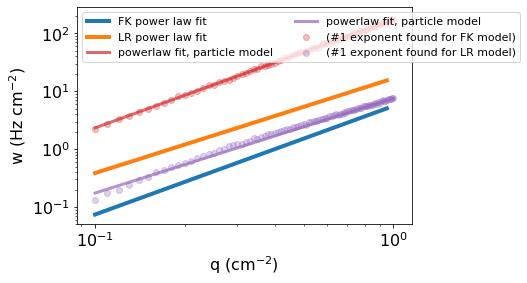

In [578]:
#plot fits for full model
m_fk=wjr['fk_pbc']['m']
m_lr=wjr['lr_pbc']['m']
M_fk=wjr['fk_pbc']['M']# Hz*cm^{2(m-1)}
M_lr=wjr['lr_pbc']['M']# Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)

xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

yscale=10**3
fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4)

#plot particle model for the FK model
plt.scatter(x1_values,y1_values,label=f'(#{k+1} exponent found for FK model)',c='C3',alpha=0.3)
plt.plot(x_values,yhat1,label=f'powerlaw fit, particle model',c='C3',alpha=.7,zorder=3,lw=3)

#plot particle model for the LR model
plt.scatter(x2_values,y2_values,label=f'(#{k+1} exponent found for LR model)',c='C4',alpha=0.3)
plt.plot(x_values,yhat2,label=f'powerlaw fit, particle model',c='C4',alpha=.7,zorder=3,lw=3)


# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5,ncol=2,loc='upper left')
plt.show()

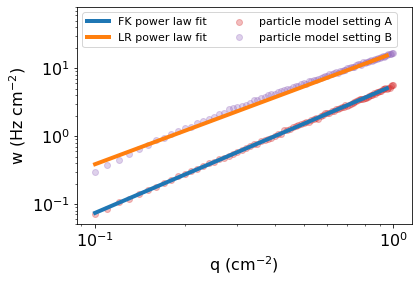

In [601]:
#plot fits for full model, with time rescaling
m_fk=wjr['fk_pbc']['m']
m_lr=wjr['lr_pbc']['m']
M_fk=wjr['fk_pbc']['M']# Hz*cm^{2(m-1)}
M_lr=wjr['lr_pbc']['M']# Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)

xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

yscale=10**3
fontsize=16
# plt.xlim([0.1,1])
plt.ylim([5e-2,80])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4)

#plot particle model for the FK model
plt.scatter(x1_values,y1_scaled_values,label=f"particle model setting A",c='C3',alpha=0.3)
# plt.scatter(x1_values,y1_scaled_values,label=f'(#{k+1} exponent found for FK model\nrescaled by M_new/M_old={scale_factor1:.2f}',c='C3',alpha=0.3)
# plt.scatter(x1_values,y1_scaled_values,label=f'(#{k+1} exponent found for FK model,\nrescaled time)',c='C3',alpha=0.3)
# plt.plot(x_values,yhat1_scaled,label=f'powerlaw fit, particle model,\nrescaled by M_new/M_old={scale_factor1:.2f}',c='C3',alpha=.7,zorder=3,lw=3)

#plot particle model for the LR model
plt.scatter(x2_values,y2_scaled_values,label=f"particle model setting B",c='C4',alpha=0.3)
# plt.scatter(x2_values,y2_scaled_values,label=f'(#{k+1} exponent found for LR model,\nrescaled by M_new/M_old={scale_factor2:.2f}',c='C4',alpha=0.3)
# plt.scatter(x2_values,y2_scaled_values,label=f'(#{k+1} exponent found for LR model,\nrescaled time)',c='C4',alpha=0.3)
# plt.plot(x_values,yhat2_scaled,label=f'powerlaw fit, particle model,\nrescaled by M_new/M_old={scale_factor2:.2f}',c='C4',alpha=.7,zorder=3,lw=3)


# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5,ncol=2,loc='upper left')
plt.show()

In [622]:
d=df.loc[trial_index_1]
print(f"printing results for particle model fit to FK model")
boo=(x1_values>=0.2)&(x1_values<=1.0)
print_fit_power_law(x1_values[boo],y1_scaled_values[boo])
print(f"^this particle model used parameters:")
print(d[input_cols])

d=df.loc[trial_index_2]
print(f"\nprinting results for particle model fit to LR model")
boo=(x2_values>=0.2)&(x2_values<=1.0)
print_fit_power_law(x2_values[boo],y2_scaled_values[boo])
print(f"^this particle model used parameters:")
print(d[input_cols])

printing results for particle model fit to FK model
m=1.868452+-0.010846; B=2.508452+-0.017746
M= 5.575331+-0.130991 Hz*cm^{2(m-1)}
RMSE=0.0640 Hz/cm^2
R^2=0.9993
^this particle model used parameters:
r             0.5
kappa       500.0
D             1.6
varkappa     80.0
Name: 2602, dtype: float64

printing results for particle model fit to LR model
m=1.554571+-0.014465; B=6.132528+-0.052504
M= 16.766458+-0.677432 Hz*cm^{2(m-1)}
RMSE=0.2560 Hz/cm^2
R^2=0.9982
^this particle model used parameters:
r             0.1
kappa       250.0
D             1.3
varkappa      4.0
Name: 6002, dtype: float64


In [616]:
# print(d)

NameError: name 'avg_value' is not defined